In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("incl/")

import ELPH_utils
import ELPH_Scaler

In [2]:
runs = ELPH_utils.load_runs()

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

# for k in range(len(runs)):
#     runs[k] = runs[k][:,:200:2]

100 loaded with n_kmax = 80


runs[0] shape:  (80, 400)


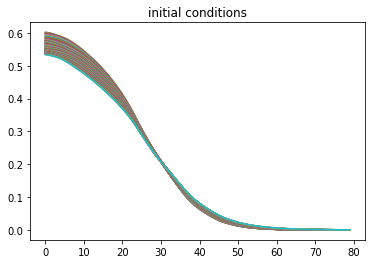

In [3]:
print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,-1])

plt.title('initial conditions')
plt.show()

rdim:  20
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (40, 39900)
NVAR state shape:  (861, 39900)
target shape:  (20, 39900)
weights shape:  (861, 20)


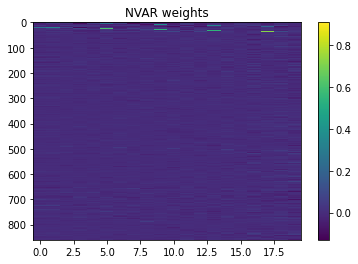

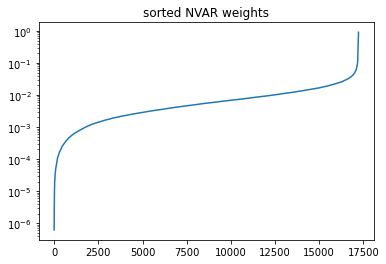

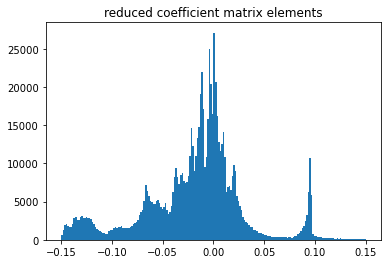

In [4]:
from ELPH_NVAR import SVDNVAR

# scaler = None
# scaler = ELPH_Scaler.standardize_scaler()
scaler = ELPH_Scaler.normalize_scaler(0.3)
# scaler = ELPH_Scaler.tanh_scaler(arg_scale=1.0, out_scale=0.3)

NVAR = SVDNVAR(runs)
NVAR.train(alpha=10**-3.4, rdim=20, n_VAR_steps=2, NVAR_p=2, intercept=True, scaler=scaler)
NVAR.print_status()

plt.imshow(NVAR.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(NVAR.w))))
plt.title('sorted NVAR weights')
plt.show()

plt.hist(np.ravel(NVAR.red_coef_matrix), bins=200)
plt.title('reduced coefficient matrix elements')
plt.show()

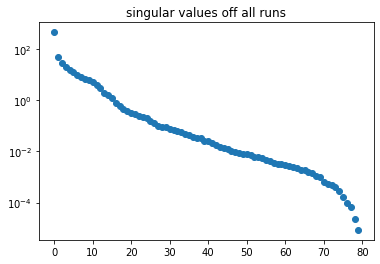

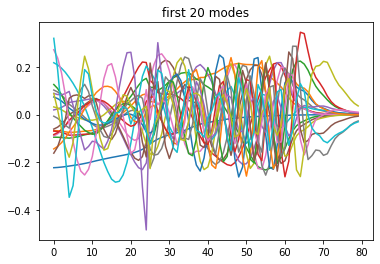

In [5]:
plt.semilogy(NVAR.S, 'o')
plt.title('singular values off all runs')
plt.show()
 
for l in range(NVAR.rdim):
  plt.plot(NVAR.U[:,l],  label='Uhat_'+str(l))
plt.title('first ' + str(NVAR.rdim) + ' modes')
plt.show()

In [6]:
scaler = ELPH_Scaler.normalize_scaler(0.3)

train_kwargs = {'alpha':10**-2.8, 'rdim':20, 'n_VAR_steps':2, 'NVAR_p':2, 'method':'ridge', 'intercept':True, 'scaler':scaler, 'full_hist':False}
score_kwargs = {'norm':'max', 'errSVD':True}

m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(np.std(s))
print(s)

0.006961702327310556
0.00039679471504783844
[0.007180323123281043, 0.007619329660512694, 0.00678926274256231, 0.006731356320250559, 0.006488239789946173]


In [7]:
def get_score(aExp, rel_scale):
    alpha = 10.0**aExp
    
    scaler = ELPH_Scaler.normalize_scaler(rel_scale)
    
    train_kwargs = {'alpha':alpha, 'rdim':20, 'n_VAR_steps':2, 'NVAR_p':2, 'method':'ridge', 'intercept':True, 'scaler':scaler, 'full_hist':False}
    score_kwargs = {'norm':'max', 'errSVD':True}
    
    m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    
    r = -1.*m - 1.*np.std(s)
    if np.isnan(r):
        r = -10.0
    return r

# print(get_score(-3.4, 0.1))

from bayes_opt import BayesianOptimization
pbounds = {'aExp':[-5, -1], 'rel_scale':[0.1,0.7]}
optimizer = BayesianOptimization(f=get_score, pbounds=pbounds, random_state=817)

# optimizer.maximize(init_points=10, n_iter=60)

In [8]:
# scores = []

# k = 1

# for aExp in np.linspace(-4,-2,15):
#     for rs in np.linspace(0.2,0.5,15):
#         print(k)
#         scores.append(get_score(aExp,rs))
#         k += 1

In [9]:
# scrs = np.array(scores)
# scrs = np.reshape(scrs,(15,15))


# plt.imshow(scrs, aspect='auto', origin='lower', vmin=-0.02, extent=[0.2,0.5,-4,-2])
# plt.colorbar()
# plt.show()

rdim:  20
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (40, 39501)
NVAR state shape:  (861, 39501)
target shape:  (20, 39501)
weights shape:  (861, 20)
NVAR error:  0.010312689667014152
NVAR error compared to SVD approximated run:  0.006194282103300308


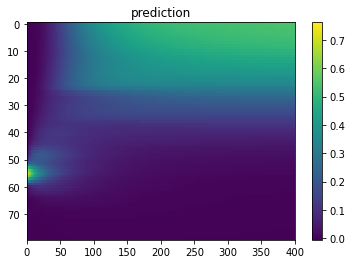

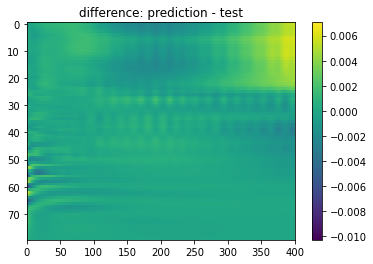

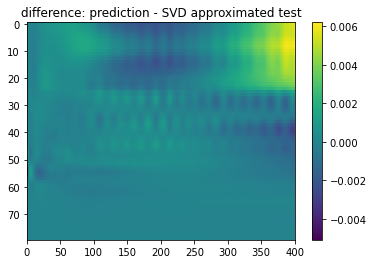

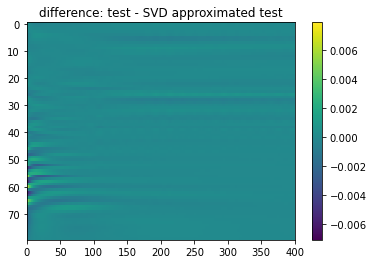

In [78]:
scaler = ELPH_Scaler.normalize_scaler(0.3)

train_runs = runs[::1]
test_run = train_runs.pop(82)

NVAR.load_runs(train_runs)
NVAR.train(rdim=20, n_VAR_steps=2, NVAR_p=2, method='ridge', alpha=10.**-2.8, intercept=True, scaler=scaler, full_hist=False)

NVAR.print_status()


print('NVAR error: ', NVAR.get_error(test_run, norm='max') )
print('NVAR error compared to SVD approximated run: ', NVAR.get_error(test_run, norm='max', errSVD=True) )

pred = NVAR.predict_single_run(test_run)
test_run_SVDapprx = NVAR.Uhat @ NVAR.Uhat.T @ test_run


xmax = runs[0].shape[1]

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(test_run-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: test - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

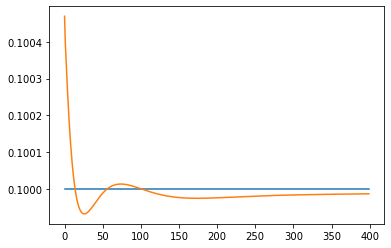

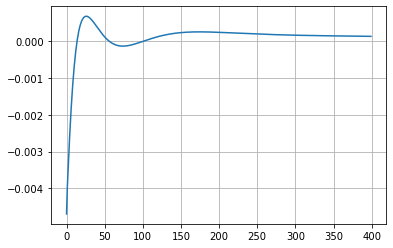

In [79]:
import ELPH_dyn

N_test = np.sum(test_run, axis=0)
N_pred = np.sum(pred, axis=0)

dk = 4./80.

def get_N(run):
    Narr = np.zeros(run.shape[1])
    for t in range(run.shape[1]):
        N = 0
        for k in range(run.shape[0]):
            N += run[k,t] * ELPH_dyn.get_k(dk,k)*dk/2./np.pi
        Narr[t] = N
        
    return Narr

N_test_noPI = get_N(test_run)
N_pred_noPI = get_N(pred)

plt.plot(N_test_noPI)
plt.plot(N_pred_noPI)
plt.show()

plt.grid()
plt.plot((N_test_noPI-N_pred_noPI)/N_test_noPI)
plt.show()

ridge regression loss: 0.023160735
(861, 39501)
(20, 39501)
step 0, loss: 0.016629105433821678
step 10, loss: 0.016573047265410423
step 20, loss: 0.01654973067343235
step 30, loss: 0.0165239404886961
step 40, loss: 0.016559144482016563
step 50, loss: 0.016520710662007332
step 60, loss: 0.016498113051056862
step 70, loss: 0.016466328874230385
step 80, loss: 0.016462290659546852
step 90, loss: 0.016446951776742935
step 100, loss: 0.016419537365436554
step 110, loss: 0.016386812552809715
step 120, loss: 0.016353728249669075
step 130, loss: 0.01633921079337597
step 140, loss: 0.016324350610375404
step 150, loss: 0.016313282772898674
step 160, loss: 0.0163230262696743
step 170, loss: 0.016334036365151405
step 180, loss: 0.01628764346241951
step 190, loss: 0.016271909698843956
regression loss: 0.0469038
rdim:  20
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (40, 39501)
NVAR state shape:  (861, 39501)
target shape:  (20, 39501)
weights shape:  (861, 20)


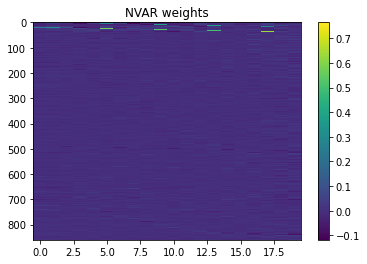

In [111]:
scaler = ELPH_Scaler.normalize_scaler(0.3)

train_runs = runs[::1]
test_run = train_runs.pop(82)

NVAR.load_runs(train_runs)
NVAR.train(rdim=20, n_VAR_steps=2, NVAR_p=2, method='sgd', alpha=10.**-2.8, lambda1=1., intercept=True, scaler=scaler, full_hist=False)

NVAR.print_status()

plt.imshow(NVAR.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()


NVAR error:  0.010327240464778509


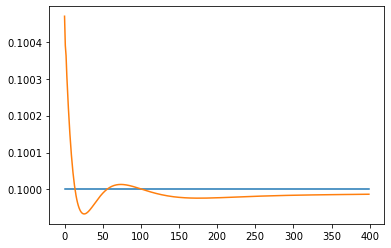

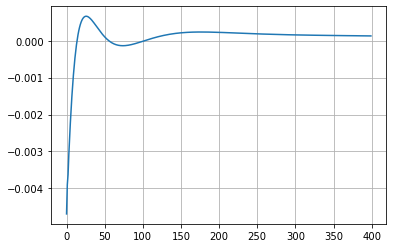

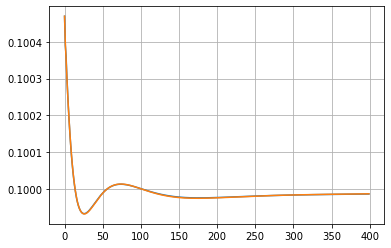

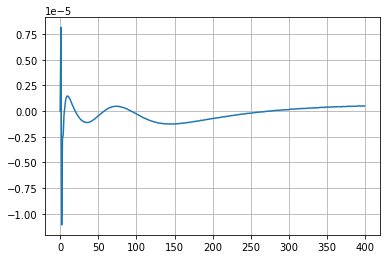

In [86]:
print('NVAR error: ', NVAR.get_error(test_run, norm='max') )


pred_PIML = NVAR.predict_single_run(test_run)


N_test = get_N(test_run)
N_pred = get_N(pred_PIML)

plt.plot(N_test)
plt.plot(N_pred)
plt.show()

plt.grid()
plt.plot((N_test-N_pred)/N_test)
plt.show()


plt.grid()
plt.plot(N_pred)
plt.plot(N_pred_noPI)
plt.show()

plt.grid()
plt.plot(N_pred_noPI-N_pred)
plt.show()